# Packages

In [2]:
# Core Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import mgarch

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

# Additional Auxilliary Functions
from scipy.stats import kurtosis, skew, jarque_bera

# Cosmetics
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
from typing import List

# Read Data

In [26]:
# full data
start_date = "1995-01-01"
end_date = "2022-12-31"

price_long = pd.read_csv("data_clean/long_format_daily.csv")
price_long["Date"] = pd.to_datetime(price_long["Date"])
price_long = price_long.loc[(price_long["Date"] >= start_date) & (price_long["Date"] <= end_date), :]

# very short data for testing
price_long_test = price_long.loc[(price_long["Date"] >= '2022-01-01'), :]
price_wide_test = price_long_test.pivot(index='Date', columns='Ticker', values='Price')
return_wide_test = price_wide_test.pct_change().iloc[1:,:]

In [44]:
# data used to replicate paper results
start_date = "2010-01-01"
end_date = "2020-06-30"

price_long_paper = pd.read_csv("data_clean/long_format_daily_original_paper_data.csv")
price_long_paper["Date"] = pd.to_datetime(price_long_paper["Date"])
price_long_paper = price_long_paper.loc[(price_long_paper["Date"] >= start_date) & (price_long_paper["Date"] <= end_date), :]
price_wide_paper = price_long_paper.pivot(index='Date', columns='Ticker', values='Price')

# VTI, AGG, DBC, VIX

# Python Functions

## Optimization Framework - Traditional

In [11]:
def portfolio_optimization(returns, loss_func:str, cov_estimation:str='historical'):
    # return the portfolio weight for 1 rebalance period 
    def constraint_basic(weights):
        return np.sum(weights) - 1
    
    def constraint_long_only(weights):
        return weights    # make sure weights are positive
    
    def objective_variance(weights):
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return portfolio_volatility
    
    def objective_sharpe(weights):
        portfolio_return = np.dot(mean_returns, weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return - portfolio_return / portfolio_volatility
    
    def objective_markowitz3(weights):
        a = 1000 # hyperparameter tuning through grid search
        b = 1
        portfolio_return = np.dot(mean_returns, weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = portfolio_return / portfolio_volatility
        entropy = np.exp(-np.sum(weights * np.log(weights)))
        return -(a * sharpe + b * entropy) / (a + b)
    
    def objective_divers_ratio(weights):
        portfolio_variance = 0
        weighted_sum = 0
        for i in range(cov_matrix.shape[0]):
            portfolio_variance += weights[i]**2*cov_matrix[i][i]
            weighted_sum += weights[i]**2*cov_matrix[i][i]
            for j in range(cov_matrix.shape[0]):
                if i>j:
                    portfolio_variance+= 2*weights[i]*weights[j]*cov_matrix[i][j]
        DR = np.sqrt(weighted_sum/portfolio_variance)
        return - DR

    def objective_marginal_risk_contribution(weights):
        portfolio_TR = 0
        portfolio_variance = 0
        for i in range(cov_matrix.shape[0]):
            portfolio_variance += weights[i]**2*cov_matrix[i][i]
            RC_i = 2*weights[i]**2*cov_matrix[i][i]
            for j in range(cov_matrix.shape[0]):
                if j!=i:
                    portfolio_variance+= weights[i]*weights[j]*cov_matrix[i][j]
                    RC_i += weights[i]*weights[j]*cov_matrix[i][j]
            portfolio_TR+=RC_i
        return portfolio_TR/np.sqrt(portfolio_variance)
    
    # basic feature
    tickers = returns.columns
    date = returns.index[-1]
    num_assets = returns.shape[1]
    mean_returns = np.mean(returns, axis=0)
    annualized_vol = returns.std() * np.sqrt(252 / 66)
    
    # Covariance Matrix:
    if cov_estimation == 'historical':
        cov_matrix = np.cov(returns.T, ddof=1)
    if cov_estimation == 'regularized':
        c = 0.00005
        cov_matrix = np.cov(returns.T, ddof=1) 
        cov_matrix += c * np.eye(cov_matrix.shape[0])
    if cov_estimation == 'DCC_GARCH':
        vol = mgarch.mgarch()
        vol.fit(returns)
        ndays = 1
        cov_matrix = vol.predict(ndays)['cov']
    
    # calculate weight by minimizing objective, subject to constraint
    constraints = [{'type': 'eq', 'fun': constraint_basic}, {'type': 'ineq', 'fun': constraint_long_only}]
    init_weights = np.array([1 / num_assets] * num_assets)
    if loss_func == 'equal_weight':
        return pd.DataFrame({'Date':date, 
                             'Ticker':tickers, 
                             'Weight':init_weights, 
                             'Annualized_vol':annualized_vol
                            })
    objective = locals()['objective_' + loss_func] # call the objective function associated with input
    weights = minimize(objective, init_weights, method='SLSQP', constraints=constraints).x
    
    return pd.DataFrame({'Date':date, 
                         'Ticker':tickers, 
                         'Weight':weights, 
                         'Annualized_vol':annualized_vol
                        })

In [12]:
def optimize_portfolio(price_long, loss_func:str, cov_estimation:str='historical', period=66):
    price_wide = price_long.pivot(index='Date', columns='Ticker', values='Price')
    return_wide = price_wide.pct_change().iloc[1:,:] #drop 1st row
    n_rebalance = return_wide.shape[0] // period
    
    chunks = [return_wide.iloc[i:i+period, :] for i in range(0, period * n_rebalance, period)]
    weights = pd.DataFrame(columns=['Date', 
                                    'Ticker', 
                                    'Weight', 
                                    'Annualized_vol'])
    
    for chunk in chunks: # each chunk is a return data (wide format)
        na_threshold = 5 # drop ticker w/ >5 NaN, fill ticker w/ <=5 NaN with 0
        returns = chunk.dropna(thresh = period-na_threshold, axis=1)
        returns = returns.fillna(0)
        chunk_weights = portfolio_optimization(returns, loss_func, cov_estimation)
        weights = pd.concat([weights, chunk_weights], axis=0, ignore_index=True)
    
    weights = pd.merge(weights, price_long[['Date', 'Ticker', 'Price']], on=['Date', 'Ticker'], how='left')
    return weights.reset_index(drop=True)

## Optimization Framework - LSTM

In [13]:
class Model:
    def __init__(self):
        self.data = None
        self.model = None
        
    def __build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])

        def sharpe_loss(_, y_pred):
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])  
            
            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            
            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def get_allocations(self, data: pd.DataFrame):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
        
        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)
        
        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))
        
        fit_predict_data = data_w_ret[np.newaxis,:]        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=20, shuffle=False,
                       verbose=0
                      )
        return self.model.predict(fit_predict_data)[0]

In [14]:
def portfolio_optimization_LSTM(price_wide):
    # basic feature
    tickers = price_wide.columns
    date = price_wide.index[-1]
    return_wide = price_wide.pct_change().dropna()
    num_assets = price_wide.shape[1]
    annualized_vol = return_wide.std() * np.sqrt(252 / 65)
    
    model = Model()
    weights = model.get_allocations(price_wide)
    
    return pd.DataFrame({'Date':date, 
                         'Ticker':tickers, 
                         'Weight':weights, 
                         'Annualized_vol':annualized_vol
                        })

In [15]:
def optimize_portfolio_LSTM(price_long, period=66):
    price_wide = price_long.pivot(index='Date', columns='Ticker', values='Price')
    n_rebalance = price_wide.shape[0] // period
    
    chunks = [price_wide.iloc[i:i+period, :] for i in range(0, period * n_rebalance, period)]
    weights = pd.DataFrame(columns=['Date', 
                                    'Ticker', 
                                    'Weight', 
                                    'Annualized_vol'])
    
    for chunk in chunks: # each chunk is a price data (wide format)
        na_threshold = 5 # drop ticker w/ >5 NaN, fill ticker w/ <=5 NaN with 0
        prices = chunk.dropna(thresh = period-na_threshold, axis=1)
        prices = prices.fillna(method = 'ffill')
        
        chunk_weights = portfolio_optimization_LSTM(prices)
        weights = pd.concat([weights, chunk_weights], axis=0, ignore_index=True)
    
    weights = pd.merge(weights, price_long[['Date', 'Ticker', 'Price']], on=['Date', 'Ticker'], how='left')
    return weights.reset_index(drop=True)

## Backtest Framework

In [16]:
# Auxuliary Functions
def maximum_drawdown(pnl: pd.Series):
    nav = (1 + pnl).cumprod()
    running_max = nav.cummax()
    drawdown = (nav - running_max) / running_max
    max_drawdown = drawdown.min()
    max_drawdown_date = drawdown.idxmin()
    
    if max_drawdown == 0:
        return [drawdown, 0, np.NaN, np.NaN]
    
    def find_nearest_zeros(series):
        min_index = series.idxmin()
        left_zero_index = series[series <= 0].loc[:min_index][::-1].idxmax()
        righ_zero_index = series[series <= 0].loc[min_index:].idxmax()
        return left_zero_index, righ_zero_index
    
    drawdown_start_date, drawdown_end_date = find_nearest_zeros(drawdown)
    recovery_days = (drawdown_end_date - drawdown_start_date).total_seconds() / 86400.0
    
    return [drawdown, max_drawdown, max_drawdown_date, recovery_days]

In [17]:
def backtest(weight_long):
    data = weight_long.copy()
    data["ret"] = data.groupby("Ticker")["Price"].transform(lambda x: x.shift(-1)/x -1)
    data["pnl"] = data["ret"] * data["Weight"]
    port_pnl = data.groupby("Date").apply(lambda x: np.sum(x["pnl"]))
    port_pnl.index = pd.to_datetime(port_pnl.index)
    port_nav = (1 + port_pnl).cumprod()
    port_vol = weight_long.groupby('Date').apply(lambda x: np.sqrt(np.sum((x['Weight'] * x['Annualized_vol'])**2)))
    
    def calc_var(port_pnl, confidence_level = 0.05):
        sorted_pnl = port_pnl.sort_values()
        index = int(confidence_level * len(sorted_pnl))
        return sorted_pnl.iloc[index]
    
    def calc_cvar(port_pnl, confidence_level = 0.05):
        var = calc_var(port_pnl, confidence_level)
        pnl_below_var = port_pnl[port_pnl <= var]
        return pnl_below_var.mean()
    
    avg_annual_ret = port_pnl.mean() * 252 / 66
    avg_annual_std = port_pnl.std() * np.sqrt(252 / 66)
    s = skew(port_pnl)
    k = kurtosis(port_pnl)
    sharpe_ratio = avg_annual_ret / avg_annual_std
    adj_sharpe_ratio = sharpe_ratio * (1 + s/6*sharpe_ratio - k/24*sharpe_ratio**2)
    drawdown_results = maximum_drawdown(port_pnl)
    
    shannon_entropy = data.groupby("Date")["Weight"].apply(lambda x: np.exp(-np.sum(x * np.log(x))))
    shannon_entropy.index = port_pnl.index
    weighted_vol = weight_long.groupby('Date').apply(lambda x: np.sum(x['Weight'] * x['Annualized_vol']))
    diversification_ratio = weighted_vol / port_vol
    
    return {'avg annualized ret': avg_annual_ret,
            'avg annualized std': avg_annual_std,
            'sharpe ratio': sharpe_ratio, 
            'adjusted sharpe ratio': adj_sharpe_ratio,
            'skewness': s,
            'excess kurtosis': k,
            'maximum drawdown': drawdown_results[1],
            'maximum drawdown length (days)': drawdown_results[3],
            'VaR (95%)': calc_var(port_pnl),
            'CVaR (95%)': calc_cvar(port_pnl),
            'shannon entropy mean': shannon_entropy.mean(),
            'shannon entropy std': shannon_entropy.std(),
            'diversification ratio mean': diversification_ratio.mean(),
            'diversification ratio std': diversification_ratio.std(),
            'effective number of uncorrelated bets': np.square(diversification_ratio).mean(),
            # time series data below
            'pnl': port_pnl,
            'nav': port_nav,
            'annualized_realized_vol': port_vol,
            'drawdown': drawdown_results[0],
            'shannon_entropy': shannon_entropy,
            'diversification_ratio': diversification_ratio,
           }


def comparison_table(result_list):
    # this compiles all numerical results (not a timeseries)
    comparison = pd.DataFrame()
    for result in result_list:
        float_values = {key: value for key, value in result.items() if isinstance(value, float)}
        tmp_df = pd.DataFrame(float_values.values(), index=float_values.keys())
        comparison = pd.concat([comparison, tmp_df], axis = 1)
    return comparison

In [18]:
plot_lists = ['nav', 
              'pnl', 
              'annualized_realized_vol', 
              'drawdown',
              'shannon_entropy', 
              'diversification_ratio'
             ]

def display_backtest_results(loss_func_names: List[str], 
                             cov_est_methods: List[str],
                             plot_lists = plot_lists,
                             price_long = price_long,
                            ):
    # run optimization & backtest
    weights = [] # weights for all the strategies
    results = [] # results for all the strategies
    for i in range(len(loss_func_names)):
        name = loss_func_names[i]
        cov_est_method = cov_est_methods[i]
        weights.append(optimize_portfolio(price_long, name, cov_est_method))
    for weight in weights:
        results.append(backtest(weight))

    # comparison table
    table = comparison_table(results)
    table.columns = [s1 + '; ' + s2 for s1, s2 in zip(loss_func_names, cov_est_methods)]
    display(table)

    # time series plots
    fig, axs = plt.subplots(len(plot_lists), figsize = (10, 5*len(plot_lists)))
    for i in range(len(plot_lists)):
        for j in range(len(results)):
            axs[i].plot(results[j][plot_lists[i]], label = f"{loss_func_names[j]}; {cov_est_methods[j]} cov")
        axs[i].legend()
        axs[i].set_title(f"{plot_lists[i]}");

# Paper Data - LSTM

In [29]:
%%time
LSTM_weights = optimize_portfolio_LSTM(price_long_paper)
LSTM_result = backtest(LSTM_weights)
comparison_table([LSTM_result])

1/1 [==============================] - 0s 348ms/step
CPU times: total: 6min 18s
Wall time: 1min 42s


,0
avg annualized ret,0.067117
avg annualized std,0.323762
sharpe ratio,0.207303
adjusted sharpe ratio,0.223497
skewness,3.051016
excess kurtosis,15.245406
maximum drawdown,-0.477077
maximum drawdown length (days),861.000000
VaR (95%),-0.154781
CVaR (95%),-0.227263


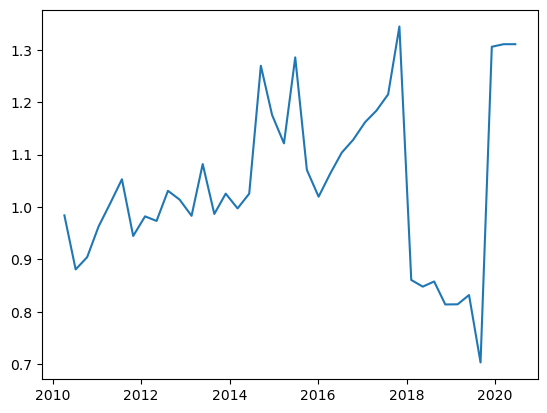

In [30]:
plt.plot(LSTM_result['nav'])

# Full Data - Traditional

## Benchmark

,sharpe; historical,variance; historical,equal_weight; historical
avg annualized ret,0.060299,0.040829,0.083887
avg annualized std,0.075368,0.038641,0.140831
sharpe ratio,0.800071,1.056642,0.595661
adjusted sharpe ratio,0.654455,0.926812,0.519063
skewness,-0.524575,-0.482747,-0.889543
excess kurtosis,4.201281,0.813728,2.724741
maximum drawdown,-0.177193,-0.127736,-0.449182
maximum drawdown length (days),924.000000,462.000000,1756.000000
VaR (95%),-0.034585,-0.026070,-0.096047
CVaR (95%),-0.071881,-0.036617,-0.144703


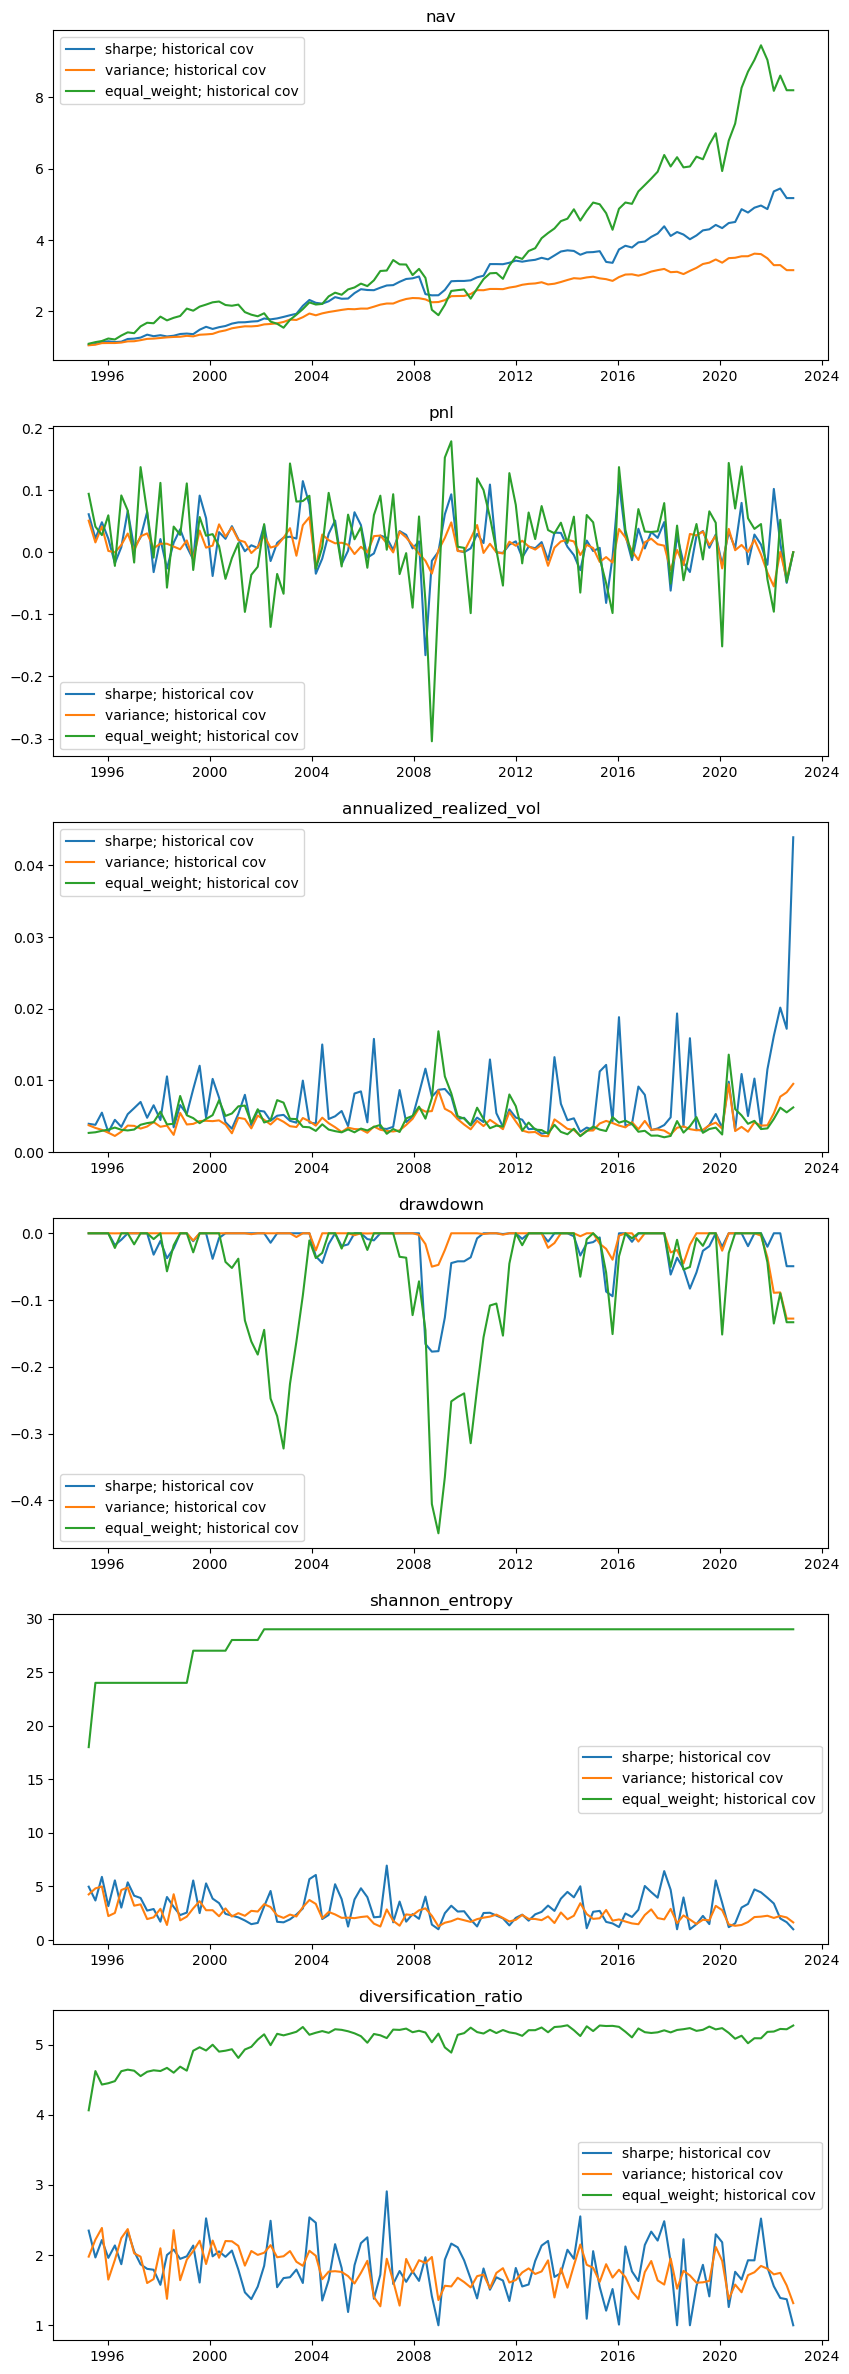

In [9]:
### Hyper Parameters for output-------------
loss_func_names = ['sharpe', 
                   'variance', 
                   'equal_weight'
                  ]

cov_est_methods = ['historical', 
                   'historical',
                   'historical'
                  ]
###-----------------------------------------

display_backtest_results(loss_func_names, cov_est_methods)

## Regularized Cov Matrix

,sharpe; historical,variance; historical,sharpe; regularized,variance; regularized
avg annualized ret,0.060299,0.040829,0.061709,0.047875
avg annualized std,0.075368,0.038641,0.104075,0.069702
sharpe ratio,0.800071,1.056642,0.592930,0.686853
adjusted sharpe ratio,0.654455,0.926812,0.575984,0.597098
skewness,-0.524575,-0.482747,-0.227424,-0.878272
excess kurtosis,4.201281,0.813728,0.416849,1.533056
maximum drawdown,-0.177193,-0.127736,-0.243950,-0.166302
maximum drawdown length (days),924.000000,462.000000,1016.000000,1016.000000
VaR (95%),-0.034585,-0.026070,-0.075324,-0.046098
CVaR (95%),-0.071881,-0.036617,-0.096211,-0.073090


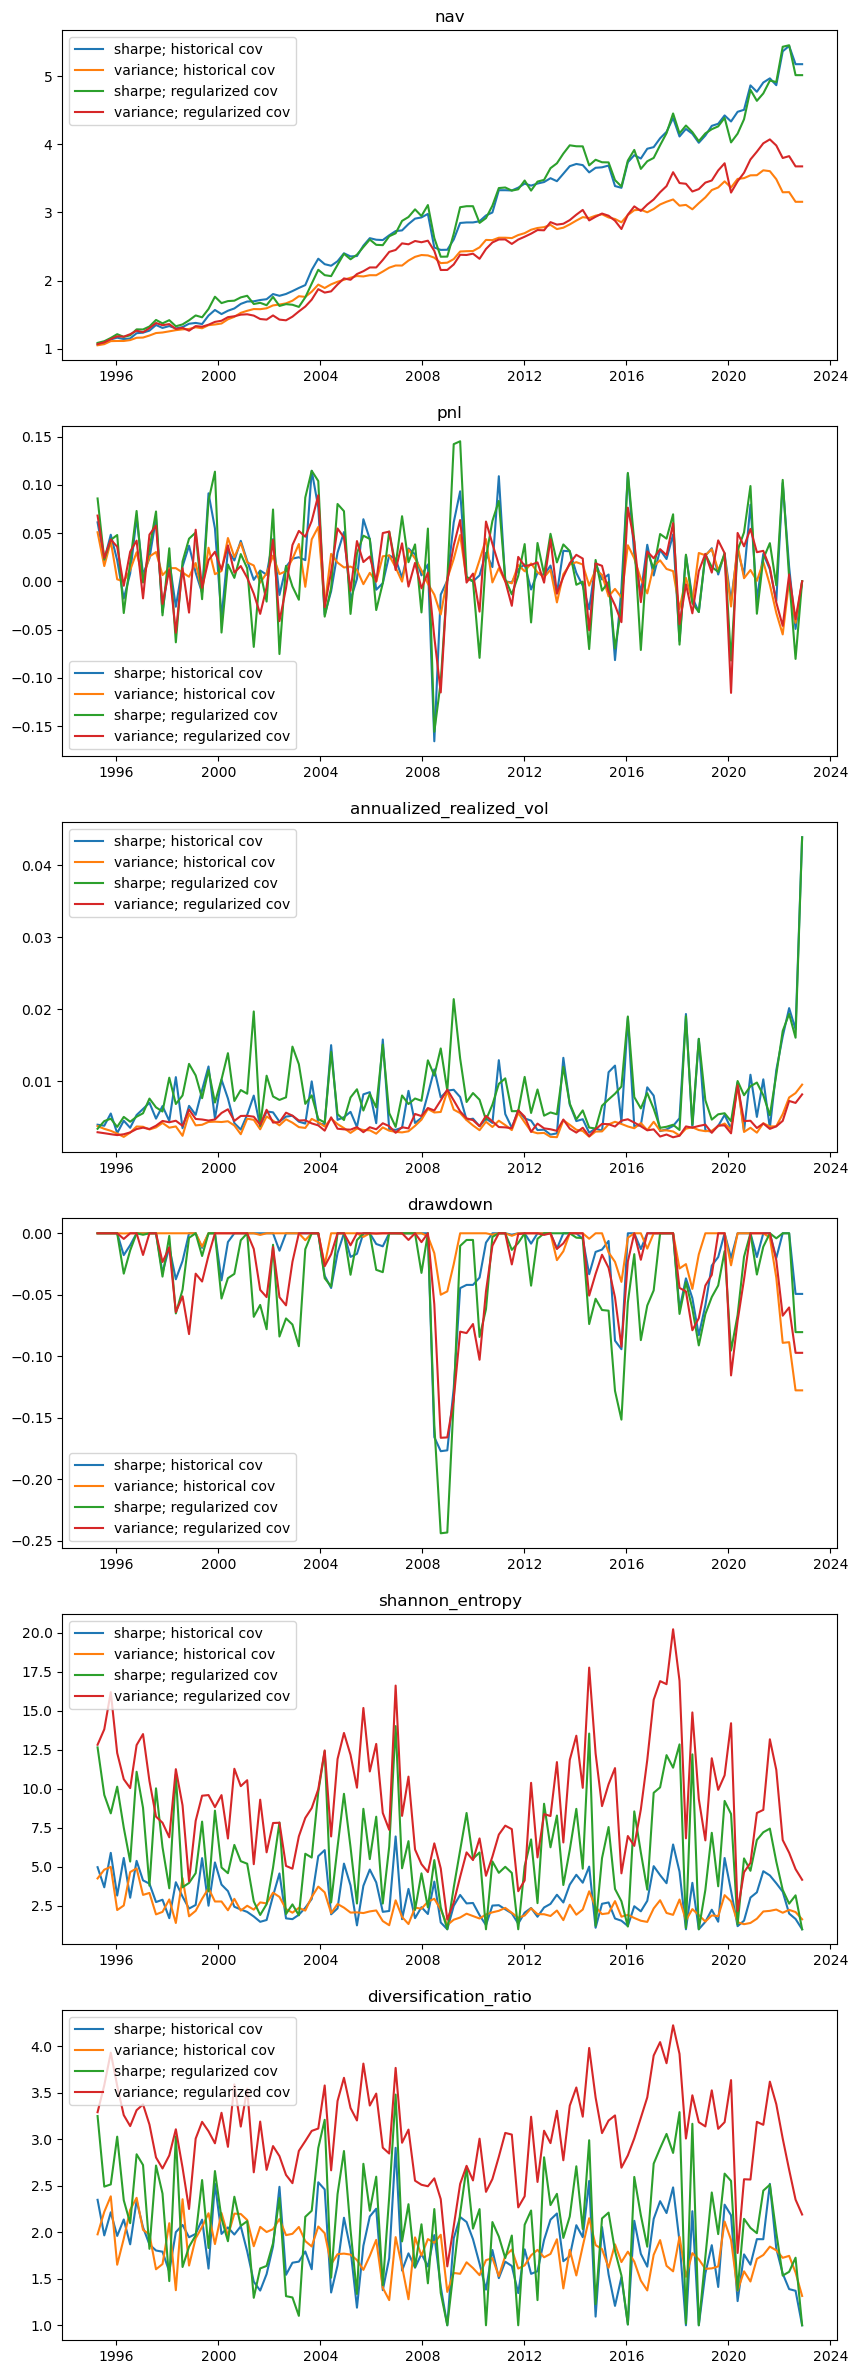

In [10]:
### Hyper Parameters for output-------------
loss_func_names = ['sharpe', 
                   'variance',
                   'sharpe', 
                   'variance',
                  ]

cov_est_methods = ['historical',
                   'historical',
                   'regularized',
                   'regularized',
                  ]
###-----------------------------------------

display_backtest_results(loss_func_names, cov_est_methods)

## Markowitz 3.0

,sharpe; historical,variance; historical,markowitz3; historical,markowitz3; regularized
avg annualized ret,0.060299,0.040829,0.051942,0.067784
avg annualized std,0.075368,0.038641,0.099435,0.105763
sharpe ratio,0.800071,1.056642,0.522372,0.640905
adjusted sharpe ratio,0.654455,0.926812,0.425286,0.622430
skewness,-0.524575,-0.482747,-1.342927,-0.235457
excess kurtosis,4.201281,0.813728,6.063340,0.214722
maximum drawdown,-0.177193,-0.127736,-0.380530,-0.256619
maximum drawdown length (days),924.000000,462.000000,2402.000000,924.000000
VaR (95%),-0.034585,-0.026070,-0.067711,-0.075862
CVaR (95%),-0.071881,-0.036617,-0.120198,-0.096172


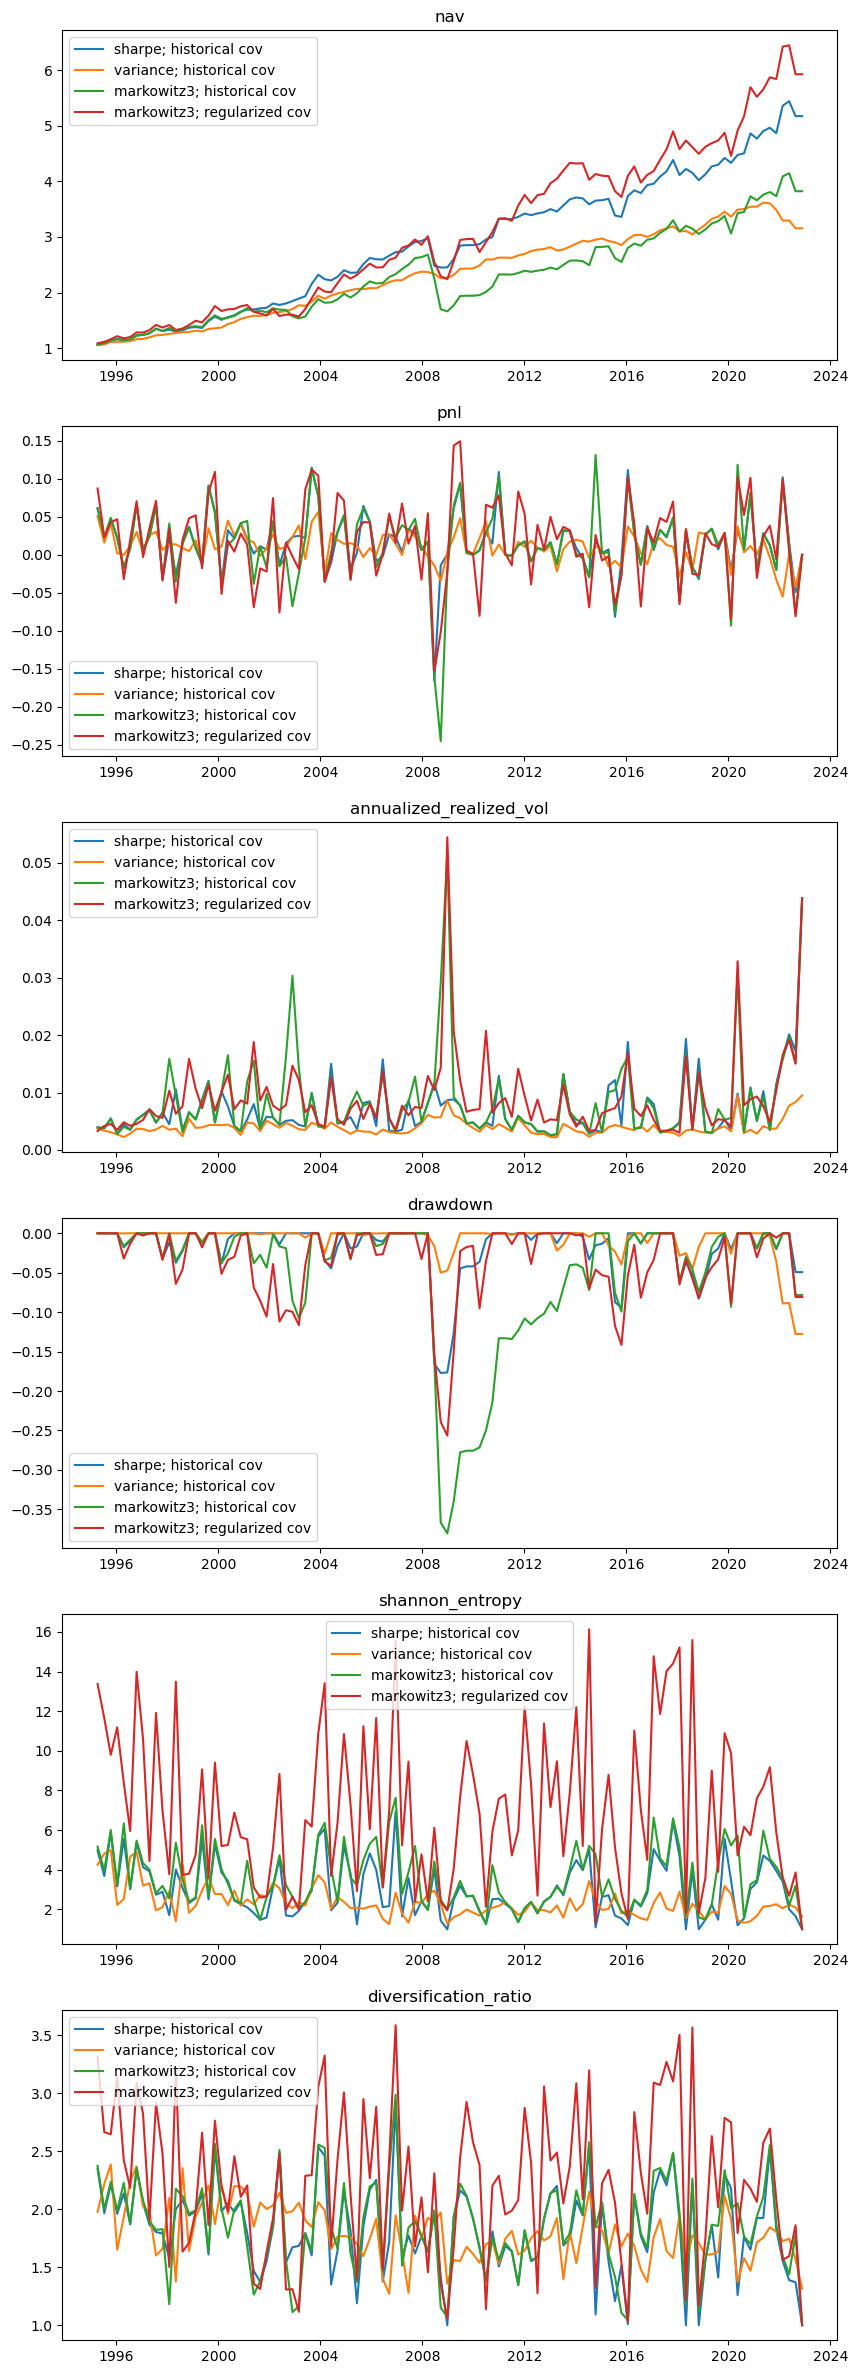

In [11]:
### Hyper Parameters for output-------------
loss_func_names = ['sharpe', 
                   'variance',
                   'markowitz3',
                   'markowitz3',
                  ]

cov_est_methods = ['historical',
                   'historical',
                   'historical',
                   'regularized',
                  ]
###-----------------------------------------

display_backtest_results(loss_func_names, cov_est_methods)

## DCC GARCH

VERY VERY VERY SLOW

In [12]:
# ### Hyper Parameters for output-------------
# loss_func_names = ['sharpe', 
#                    'sharpe',
#                    'variance',
#                    'variance',
#                   ]

# cov_est_methods = ['historical',
#                    'DCC_GARCH',
#                    'historical',
#                    'DCC_GARCH',
#                   ]
# ###-----------------------------------------

# display_backtest_results(loss_func_names, cov_est_methods)

## Maximizing Diversification Ratio

,sharpe; historical,variance; historical,equal_weight; historical,divers_ratio; historical
avg annualized ret,0.060299,0.040829,0.083887,0.030900
avg annualized std,0.075368,0.038641,0.140831,0.096540
sharpe ratio,0.800071,1.056642,0.595661,0.320080
adjusted sharpe ratio,0.654455,0.926812,0.519063,0.307593
skewness,-0.524575,-0.482747,-0.889543,-0.372463
excess kurtosis,4.201281,0.813728,2.724741,4.484424
maximum drawdown,-0.177193,-0.127736,-0.449182,-0.268155
maximum drawdown length (days),924.000000,462.000000,1756.000000,5636.000000
VaR (95%),-0.034585,-0.026070,-0.096047,-0.079919
CVaR (95%),-0.071881,-0.036617,-0.144703,-0.122744


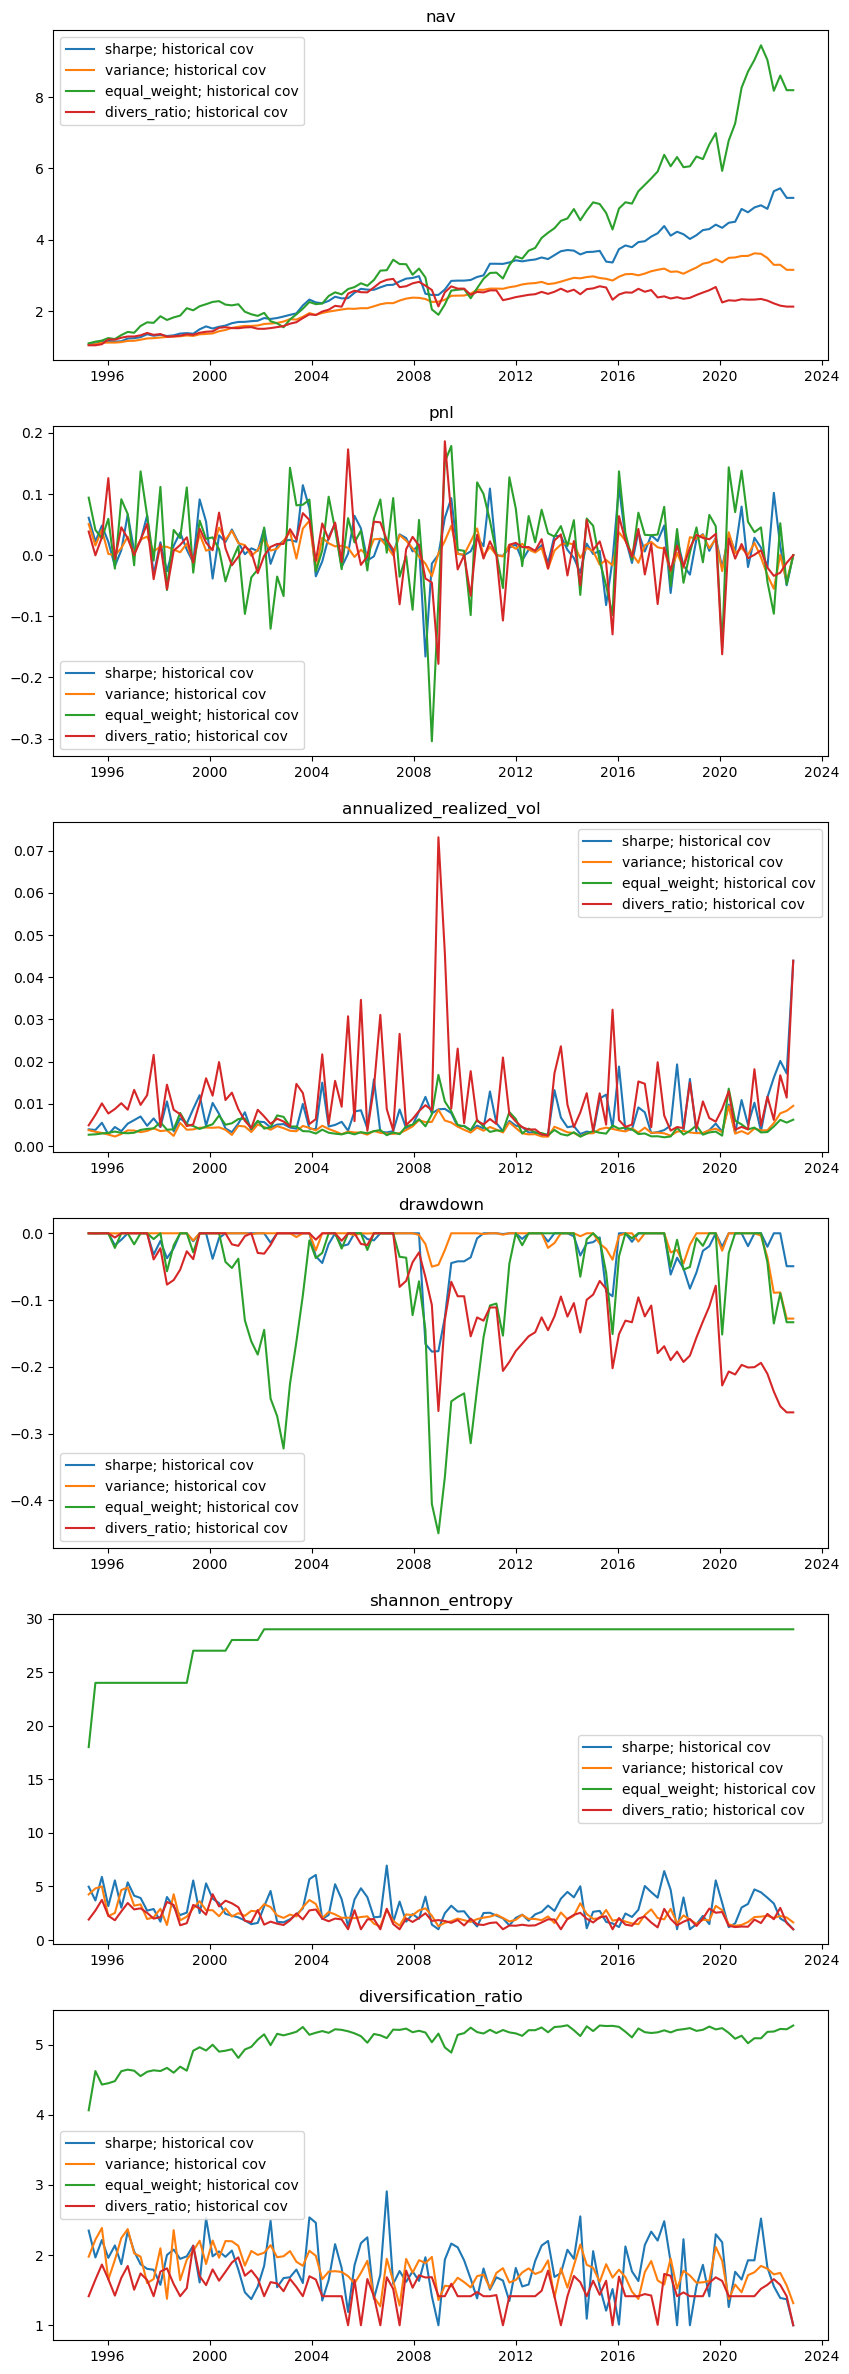

In [13]:
### Hyper Parameters for output-------------
loss_func_names = ['sharpe', 
                   'variance',
                   'equal_weight',
                   'divers_ratio',
                  ]

cov_est_methods = ['historical',
                   'historical',
                   'historical',
                   'historical',
                  ]
###-----------------------------------------

display_backtest_results(loss_func_names, cov_est_methods)

## Minimizing Marginal Risk Contribution

,sharpe; historical,variance; historical,marginal_risk_contribution; historical
avg annualized ret,0.060299,0.040829,0.045934
avg annualized std,0.075368,0.038641,0.048753
sharpe ratio,0.800071,1.056642,0.942167
adjusted sharpe ratio,0.654455,0.926812,0.846894
skewness,-0.524575,-0.482747,-0.430626
excess kurtosis,4.201281,0.813728,0.905744
maximum drawdown,-0.177193,-0.127736,-0.111057
maximum drawdown length (days),924.000000,462.000000,368.000000
VaR (95%),-0.034585,-0.026070,-0.031263
CVaR (95%),-0.071881,-0.036617,-0.047082


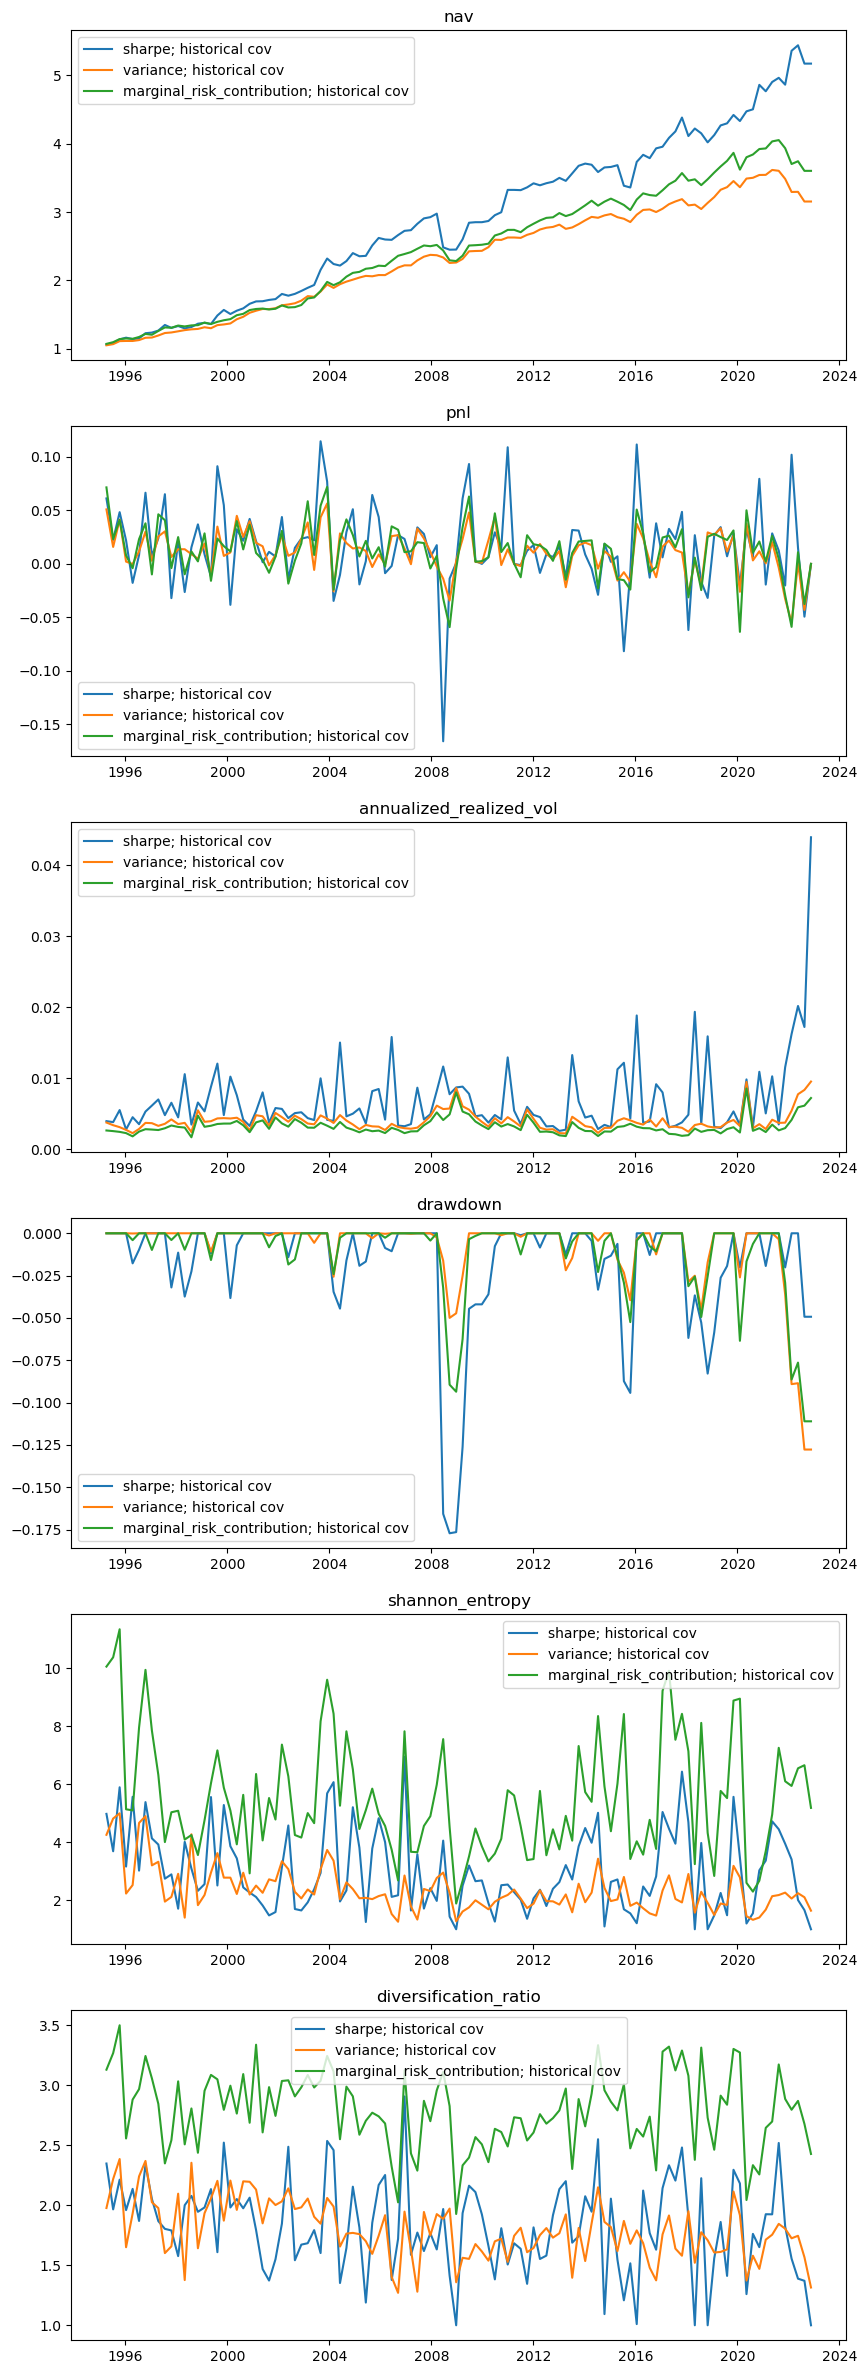

In [14]:
### Hyper Parameters for output-------------
loss_func_names = ['sharpe', 
                   'variance',
                   'marginal_risk_contribution',
                  ]

cov_est_methods = ['historical',
                   'historical',
                   'historical',
                  ]
###-----------------------------------------

display_backtest_results(loss_func_names, cov_est_methods)

# Full Data - LSTM

In [61]:
LSTM_weights = optimize_portfolio_LSTM(price_long)
LSTM_weights

1/1 [==============================] - 0s 460ms/step


,Date,Ticker,Weight,Annualized_vol,Price
0,1995-04-05,BCOMTR,0.111720,0.010144,116.431
1,1995-04-05,LBUSTRUU,0.056726,0.005384,606.600
2,1995-04-05,RU10GRTR,0.061149,0.008946,172.560
3,1995-04-05,RU10VATR,0.047128,0.008949,181.440
4,1995-04-05,RU20GRTR,0.017322,0.009390,1154.520
...,...,...,...,...,...
3006,2022-11-18,S5MATR,0.024564,0.037363,502.640
3007,2022-11-18,S5RLST,0.011065,0.038695,238.250
3008,2022-11-18,S5TELS,0.022174,0.042279,166.310
3009,2022-11-18,S5UTIL,0.045006,0.034932,348.100


In [62]:
LSTM_result = backtest(LSTM_weights)
LSTM_result

{'avg annualized ret': 0.07535135401739429,
 'avg annualized std': 0.14240957442597865,
 'sharpe ratio': 0.5291171911798688,
 'adjusted sharpe ratio': 0.4783343359284181,
 'skewness': -0.8018804891932678,
 'excess kurtosis': 2.1655662784120553,
 'maximum drawdown': -0.4709571463625875,
 'maximum drawdown length (days)': 2310.0,
 'VaR (95%)': -0.10934820243566341,
 'CVaR (95%)': -0.1644997238728901,
 'shannon entropy mean': 22.36646,
 'shannon entropy std': 4.918051242828369,
 'diversification ratio mean': 4.283682401525837,
 'diversification ratio std': 0.4935137916079245,
 'effective number of uncorrelated bets': 18.591214556635304,
 'pnl': Date
 1995-04-05    0.090660
 1995-07-10    0.021556
 1995-10-11    0.047876
 1996-01-11    0.046199
 1996-04-12   -0.029055
                 ...   
 2021-11-15   -0.040897
 2022-02-15   -0.082643
 2022-05-18    0.039359
 2022-08-18   -0.065301
 2022-11-18    0.000000
 Length: 110, dtype: float64,
 'nav': Date
 1995-04-05    1.090660
 1995-07-10   

In [64]:
comparison_table([LSTM_result])

,0
avg annualized ret,0.075351
avg annualized std,0.142410
sharpe ratio,0.529117
adjusted sharpe ratio,0.478334
skewness,-0.801880
excess kurtosis,2.165566
maximum drawdown,-0.470957
maximum drawdown length (days),2310.000000
VaR (95%),-0.109348
CVaR (95%),-0.164500


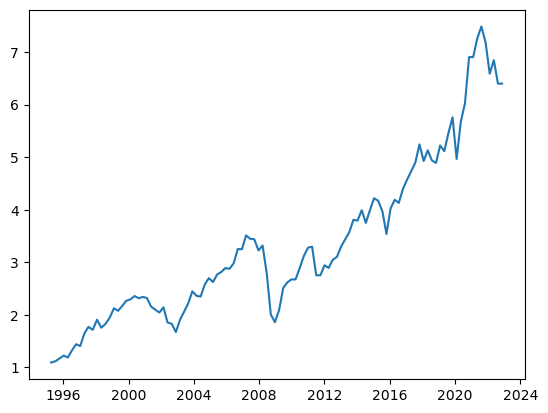

In [65]:
plt.plot(LSTM_result['nav'])

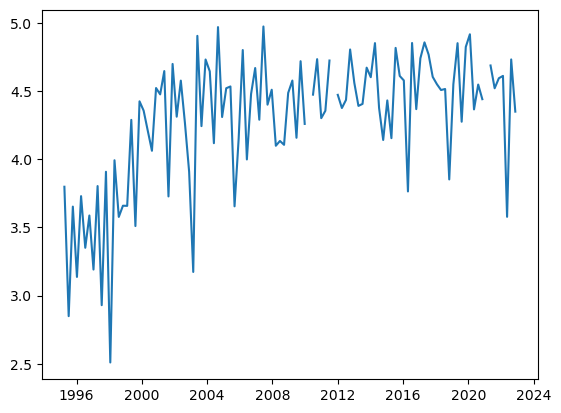

In [66]:
plt.plot(LSTM_result['diversification_ratio'])